In [1]:
%reload_ext autoreload
%autoreload 2
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io.wavfile as wv
import scipy.signal as sig
import wave

from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense

from util import util
from util import WavFileParts
from util.confusionMatrix import ConfusionMatrix


Using TensorFlow backend.


### globale settings

In [2]:
classes = ['music', 'voice', 'environment']

macDir = '/Volumes/SAA_DATA/datasets/'
winDir = 'E:/SAA_DATA/'
osDir = winDir

baseTargetDir = '/Users/etto/Desktop/pData'
baseTargetDir = 'E:/SAA_DATA/targetDir'

baseSrcDir = osDir + 'localizationFiles/20171025AllExtractionsMic4'
orgWavDirs1 = ['G428_0.0_1.4',
              'G527_0.5_1.4',
              'Studio_2.0_4.2'
              ]

orgWavDirs2 = ['G428_2.1_2.4',
              'G527_1.2_5.8',
              'Studio_3.0_2.0'
              ]

NFFT = 1024

storageFolder = '../storedData/'
chunksBaseDir = 'chunks'
rooms = ['Studio', 'G428', 'G527']

### utility functies

In [3]:
def readSoundChunksDynamic(moduleString):
    chunks = importlib.import_module(moduleString).soundChunks
    wfPts = []
    for jsonString in chunks:
        wfPts.append(WavFileParts.WavFilePartFromJson(jsonString))
    return wfPts

def timeFunction(func):
    """
    Aanroep: bijv. fpc = timeFunction(lambda: getFilesPerCategory(srcDir))
    """
    startTime = datetime.now()
    print('Start: ' + startTime.strftime('%H:%M:%S') + '\n=================')

    res = func()
    
    endTime = datetime.now()
    print('\n=================\nEnd: ' + endTime.strftime('%H:%M:%S'))
    print('Time taken: '),
    print(endTime - startTime)
    print()
    
    return res
    
def storeTestData(allSpectros, allClasses, storageName, keyName):
    filename = storageFolder + storageName + '.hd5'
    df = pd.DataFrame(allSpectros)
    df.to_hdf(path_or_buf=filename, key='spectros_' + keyName)

    df = pd.DataFrame(allClasses)
    df.to_hdf(path_or_buf=filename, key='classes_' + keyName)

def retrieveTestData(storageName, keyName):
    filename = storageFolder + storageName + '.hd5'
    specDf = pd.read_hdf(path_or_buf=filename, key='spectros_' + keyName)
    classesDf = pd.read_hdf(path_or_buf=filename, key='classes_' + keyName)
    return specDf, classesDf
    

### functies tbv trainen

In [4]:
# Maakt een dictionary aan; per categorie alle files (volledig pad) uit de srcDir
# srcDir is een van de orgWavDirs, bijvoorbeeld
#    localizationFiles/20171025AllExtractionsMic4/G428_0.0_1.4
def getFilesPerCategory(srcDir):
    filesPerCategory = {}
    for catDirLong in glob.glob(srcDir + '/*'):
        catDir = catDirLong.replace('\\', '/')
        catDir = catDir.replace(srcDir + '/', '')

        filesPerCategory[catDir] = []
        for filename in glob.glob(catDirLong + '/*'):
            filename = filename.replace('\\','/')
            filesPerCategory[catDir].append(filename)
    return filesPerCategory

In [5]:
# Maakt een dictionary aan; per categorie de spectrogrammen
def getSpectrosFromFilesPerCategory(filesPerCategory):
    spectros = {}
    for clz in classes:
        spectros[clz] = []
        for filename in filesPerCategory[clz]:
            fs, signal = wv.read(filename)
            freq_array, segment_times, spectrogram = sig.spectrogram(x=signal, fs=fs, nfft=NFFT, noverlap=0)
            spectros[clz].append(spectrogram.T)
    return spectros

In [6]:
def getClassLengths(spectrosPerCat):
    clzLengths = {}
    for clz in classes:
        clzLengths[clz] = sum([np.shape(lst)[0] for lst in spectrosPerCat[clz]])
    return clzLengths

In [7]:
# verwacht invoer van getSpectrosFromFilesPerCategory
# levert traindata op (X_train en Y_train)
def createTrainDataFromSpectros(spectrosPerCat, clzLengths):
    X_train = np.concatenate(spectrosPerCat[classes[0]], axis=0)
    for i in range(1, len(classes)):
        nwSpectros = np.concatenate(spectrosPerCat[classes[i]], axis=0)
        X_train = np.concatenate((X_train,nwSpectros), axis=0)
    
    # one-hot encoding voor Y_train
    nrFiles = clzLengths[classes[0]]
    Y_train = np.array((np.ones(nrFiles),np.zeros(nrFiles), np.zeros(nrFiles))).T

    nrFiles = clzLengths[classes[1]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.ones(nrFiles), np.zeros(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)

    nrFiles = clzLengths[classes[2]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.zeros(nrFiles), np.ones(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)
    
    return X_train, Y_train

### deep learning model

In [8]:
def create_model(layersizes):
    # create model
    model = Sequential()
    model.add(Dense(layersizes[0], input_dim=513, activation='relu'))
    for lsize in layersizes[1:]:
        model.add(Dense(lsize, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
def getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs):
    modelFilename = modelFilePath + baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    modelFilename += '.hd5'
    return modelFilename

In [27]:
def train_model(X_train, Y_train, layers, nrEpochs, modelFilePath, baseModelFilename):
    soundModel = create_model(layers)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()

In [28]:
def evaluate_model(X_test, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename):
    soundModel = load_model(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))

    # predicted classes
    predictions = soundModel.predict(X_test)
    predClasses = predictions.argmax(axis=1)

    matrix = ConfusionMatrix(classes)
    for vals in zip(realClasses, predClasses):
        matrix.add(int(vals[0]), int(vals[1]), 1)
    print(matrix.toString())
    print()
    print(matrix.toF1String())
    return matrix

### trainen van model

In [19]:
# bepaal train data
srcDir = baseSrcDir + '/' + orgWavDirs1[0]
fpc = getFilesPerCategory(srcDir)
spcs = getSpectrosFromFilesPerCategory(fpc)
clzLengths = getClassLengths(spcs)
X_train, Y_train = createTrainDataFromSpectros(spcs, clzLengths)
# real train classes
realTrainClasses = np.concatenate((np.zeros(clzLengths[classes[0]]), 
                              np.ones(clzLengths[classes[1]]), 
                              2*np.ones(clzLengths[classes[2]])))


Start: 16:08:13
Epoch 1/2
187316/187316 [==============================] - 21s 111us/step - loss: 0.2075 - acc: 0.9224
Epoch 2/2
187316/187316 [==============================] - 19s 103us/step - loss: 0.1284 - acc: 0.9530

End: 16:08:53
Time taken: 
0:00:40.585557



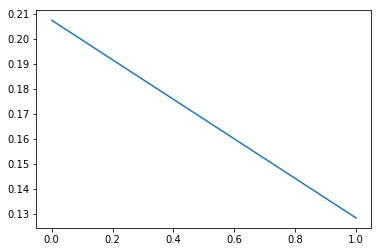

In [31]:
modelFileBaseName = '20180719'
layers = [100, 20]
nrEpochs = 2
train_model(X_train, Y_train, layers, nrEpochs, storageFolder, modelFileBaseName)


### evalueren op traindata

In [32]:
 evaluate_model(X_train, realClasses, layers, nrEpochs, storageFolder, modelFileBaseName)

                   m       v       e |  sens   acc
music          56669    3483      53 |  0.94  0.98
voice           1019   58559    1281 |  0.96  0.96
environment      123    1622   64507 |  0.97  0.98
--------------------------------------
prec            0.98    0.92    0.98

F1 overall: 0.96
F1 music: 0.96
F1 voice: 0.94
F1 environment: 0.98



### functies tbv testen

In [11]:
def createAndStoreTestData(wavFileParts, fileData, micNr, filename, keyName):
    allSpectros = np.array([])
    allClasses = np.array([])

    for wfPt in wavFileParts: #type: WavFilePart
        if not 'Gunshot' in wfPt.getSoundType():
            filename = datasetDir + '/{:d}_{:d}_mono{:d}.wav'.format(fileDate, wfPt.fileNr, micNr)
            fs, signal = wv.read(filename)

            classNr = classes.index(wfPt.getSoundType().lower())
            for soundChunk in wfPt.getSoundChunks(micNr):
                startFrame = int(soundChunk[0] * fs)
                endFrame = int(soundChunk[1] * fs)

                sigChunk = signal[startFrame: endFrame]
                freq_array, segment_times, spectrogram = sig.spectrogram(x=sigChunk, fs=fs, nfft=NFFT, noverlap=0)
                if len(allSpectros) == 0:
                    allSpectros = spectrogram.T
                else:
                    allSpectros = np.append(allSpectros, spectrogram.T, axis=0)
                allClasses = np.append(allClasses, classNr * np.ones(len(segment_times)))
                
    storeTestData(allSpectros, allClasses, filename, keyName)
